# Predicting Group Responsible - Initial Model Evaluation

**Table of Contents**
<div id="toc"></div>

Exploration of models without feature extraction

## Preparation

In [1]:
%matplotlib inline

import ConfigParser
config = ConfigParser.ConfigParser()
config.read('config.ini')

import pandas as pd
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [8]:
from IPython.display import display

if config.getboolean('Booleans', 'UseLessFeatures') == True:
    n_features = 5
else:
    n_features = 11
    
gtd = pd.read_csv('gtd_processed_%dfeatures.csv' % n_features, encoding='latin1', low_memory=False)

display(gtd.tail(5))
gtd.shape

,gname,iyear,country,attacktype1,weaptype1,targtype1
88652,Taliban,2016,4,9,13,4
88653,Taliban,2016,4,3,6,17
88654,Boko Haram,2016,146,9,13,4
88655,Lord's Resistance Army (LRA),2016,229,6,13,14
88656,Sudan Liberation Movement,2016,195,2,5,14


(88657, 6)

Split-out validation dataset

## Data Partitioning

In [3]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Model Building

In [4]:
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

if config.getboolean('Booleans', 'RunPoorPerformingClassifiers') == True:
    models.append(('GNB', GaussianNB())) # GNB: 0.353792% (0.002758) - 9.339 seconds
    models.append(('LDA', LinearDiscriminantAnalysis())) #LDA: 0.285051% (0.004282) - 5.299 seconds

if config.getboolean('Booleans', 'RunRandomForest') == True:
    models.append(('RF', RandomForestClassifier()))

if config.getboolean('Booleans', 'RunSVM') == True:
    models.append(('SVM', SVC(probability=True))) #Too slow for this many samples - O(N^3)
    
results = []
names = []
scoring = 'accuracy'
 
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNN: 0.686920% (0.006508) - 9.379 seconds
CART: 0.715031% (0.006543) - 8.819 seconds
RF: 0.706984% (0.006296) - 66.772 seconds


### Results: 11 Features, .Tail(10000)
LDA: 0.426000% (0.014946) - 0.313 seconds

KNN: 0.726875% (0.012071) - 0.312 seconds

CART: 0.762125% (0.011389) - 0.371 seconds

RF: 0.716222% (0.016347) - 3.136 seconds

GNB: 0.102750% (0.009401) - 0.763 seconds

SVM: 0.723875% (0.014879) - 342.715 seconds

### Results: 11 Features, All Rows
LDA: 0.302968% (0.005750) - 6.834 seconds

KNN: 0.657032% (0.005536) - 8.244 seconds

CART: 0.706761% (0.004214) - 12.792 seconds

GNB: 0.064843% (0.003521) - 17.24 seconds

RF: 0.684877% (0.004442) - 112.637 seconds

### Results: 5 Features, All Rows

LDA: 0.297001% (0.007324) - 86.24 seconds

KNN: 0.686920% (0.006508) - 16.632 seconds

CART: 0.714717% (0.006382) - 12.422 seconds

GNB: 0.125779% (0.011488) - 62.726 seconds

RF: 0.706546% (0.004620) - 92.779 seconds

## Compare Algorithms

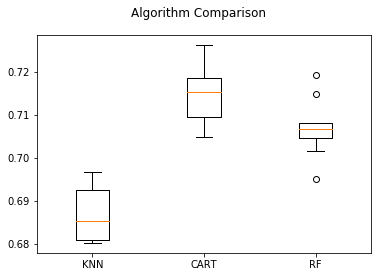

In [5]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Make predictions on validation dataset

In [6]:
cart = DecisionTreeClassifier()
cart.fit(X_train, Y_train)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions)) #TODO: sort out formatting of table - trim name column?

0.717798330702
[[1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 2 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                               precision    recall  f1-score   support

                                                                        1 May       1.00      1.00      1.00         1
                                                                   14 K Triad       1.00      1.00      1.00         1
                        16 January Organization for the Liberation of Tripoli       0.40      1.00      0.57         2
                                                                2 April Group       0.50      1.00      0.67         1
                                                  20 December Movement (M-20)       1.00      1.00      1.00         3
                                           23rd of September Communist League       0.50      0.50      0.50         4
                       

/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Predicting Live Data

Change values to see predicted Terrorist group: (for more info on values, see http://www.start.umd.edu/gtd/downloads/Codebook.pdf)

In [13]:
iyear = 2016
country = 153
crit1 = 1
crit2 = 1
crit3 = 1
attacktype1 = 1 
targtype1 = 3
targsubtype1 = 25
weaptype1 = 6
weapsubtype1 = 15
ransom = 0
#TODO: make these variables interactice controls

if n_features == 5:
    X = [iyear, country, attacktype1, targtype1, weaptype1], #TODO: reshape to 1D array
else:
    X = [iyear, country, crit1, crit2, crit3, attacktype1, targtype1, targsubtype1, weaptype1, weapsubtype1, ransom], #TODO: reshape to 1D array

print cart.predict(X)
# print cart.predict_proba(X)

[u'Khorasan Chapter of the Islamic State']
